# Prompt-to-Prompt with Latent Diffusion

### Imports, constants, loading model

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/10-423_GenAI/handout_hw4'
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/10-423_GenAI/handout_hw4
/content/drive/MyDrive/Colab Notebooks/10-423_GenAI/handout_hw4


In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
from diffusers import DiffusionPipeline
%load_ext autoreload
%autoreload 2
import prompt2prompt as ptp

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
model_id = "CompVis/ldm-text2im-large-256"
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 5.
MAX_NUM_WORDS = 77
# load model and scheduler
ldm = DiffusionPipeline.from_pretrained(model_id).to(device)
tokenizer = ldm.tokenizer

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

{'set_alpha_to_one'} was not found in config. Values will be initialized to default values.
{'cross_attention_dim'} was not found in config. Values will be initialized to default values.


## Baselines

### Baseline: Cross-Attention Visualization (and initialization of "latent")

  0%|          | 0/50 [00:00<?, ?it/s]

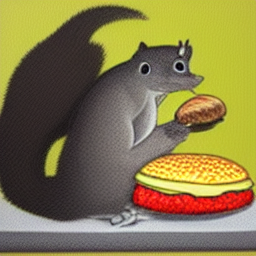

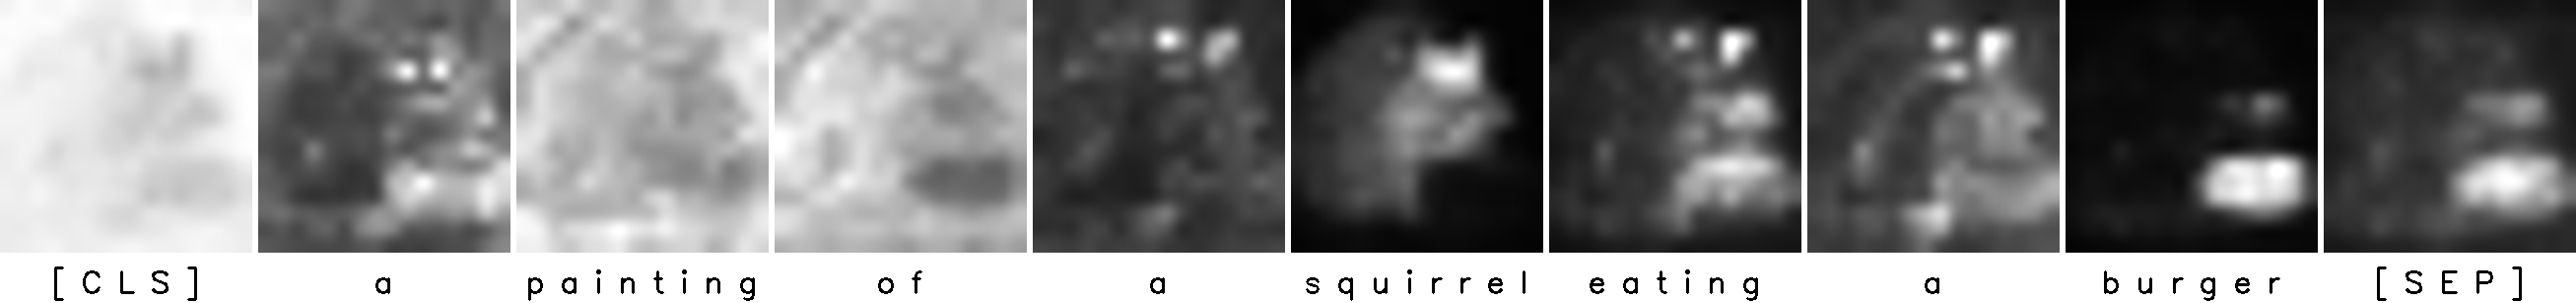

In [4]:
g_cpu = torch.Generator().manual_seed(42)
prompts = ["A painting of a squirrel eating a burger"]
# Use AttentionStore to keep track of all the attention weights
controller = ptp.AttentionStore()
# Get the base attention (store in "latent") from the first prompt
images, latent = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=None, generator=g_cpu)
# Use AttentionStore to visualize the cross-attention
ptp.show_cross_attention(tokenizer, prompts, controller, res=16, from_where=["up", "down"])

### Baseline: No Attention Controller

results without prompt-to-prompt


  0%|          | 0/50 [00:00<?, ?it/s]

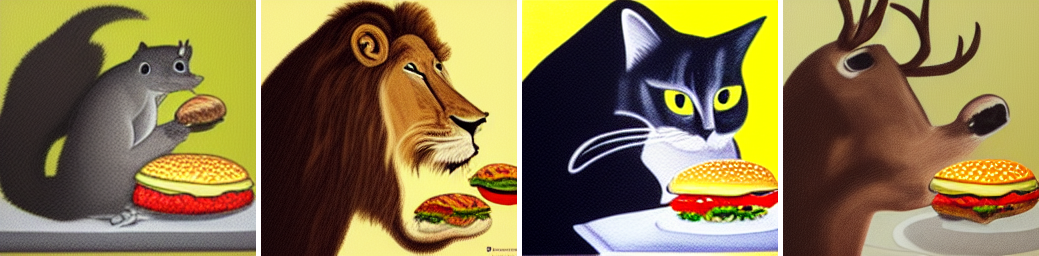

In [5]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a lion eating a burger",
           "A painting of a cat eating a burger",
           "A painting of a deer eating a burger",
          ]
print("results without prompt-to-prompt")
controller = ptp.EmptyControl()
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)

## Prompt-to-Prompt

(Note: Before you run any of the cells in this section, you must first run the  'Baseline: Cross Attention Visualization' cell above to initialize the variable "latent".)


### Prompt-to-Prompt: Word-swap

results with prompt-to-prompt


  0%|          | 0/50 [00:00<?, ?it/s]

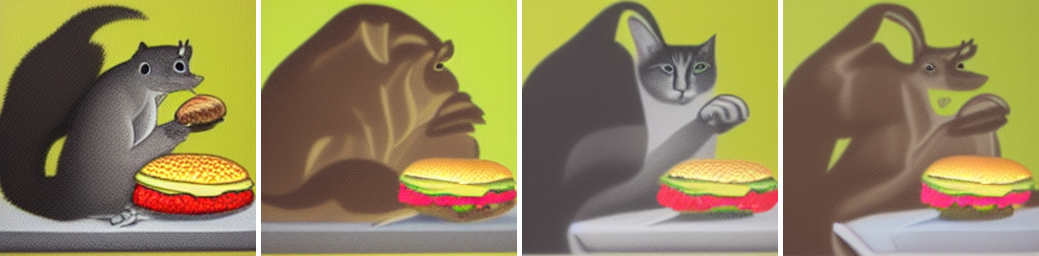

In [6]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a lion eating a burger",
           "A painting of a cat eating a burger",
           "A painting of a deer eating a burger",
          ]
print("results with prompt-to-prompt")
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps=.8, self_replace_steps=.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)

### Prompt-to-Prompt: Modify Cross-Attention injection #steps for specific words
Next, we can reduce the restriction on our lion by reducing the number of cross-attention injection with respect to the replacement words.

  0%|          | 0/50 [00:00<?, ?it/s]

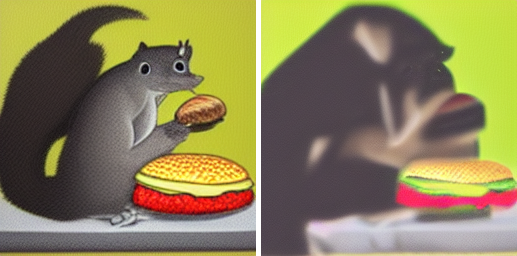

  0%|          | 0/50 [00:00<?, ?it/s]

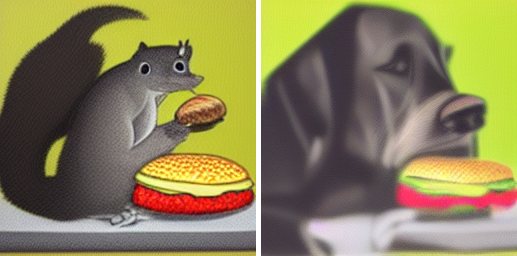

  0%|          | 0/50 [00:00<?, ?it/s]

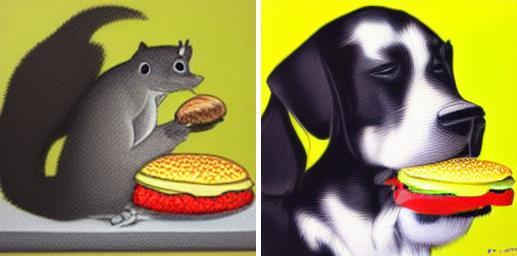

In [17]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a dog eating a burger",
          ]
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "dog": 0.9}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "dog": 0.5}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "dog": 0.1}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)

### Prompt-to-Prompt: Local Edit
Lastly, if we want to only replace the burger, we can apply a local edit with respect to to the replacement words.

  0%|          | 0/50 [00:00<?, ?it/s]

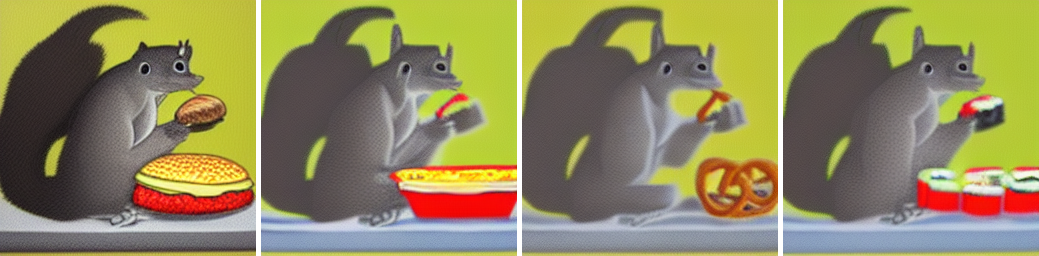

In [18]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a squirrel eating a lasagne",
           "A painting of a squirrel eating a pretzel",
           "A painting of a squirrel eating a sushi",
          ]

controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "lasagne": .2, "pretzel": .2, "sushi": .2}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)

### Prompt-to-Prompt: Custom

  0%|          | 0/50 [00:00<?, ?it/s]

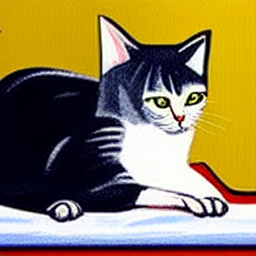

In [18]:
prompts = ["A painting of a cat sitting on a table",
           "A painting of a bird sitting on a table",
           "A painting of a mouse sitting on a table",
           "A painting of a rabbit sitting on a table",
          ]
g_cpu = torch.Generator().manual_seed(42)
# Use AttentionStore to keep track of all the attention weights
controller = ptp.AttentionStore()
images, latent = ptp.run_and_display(prompts[0:1], controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=None, generator=g_cpu)

  0%|          | 0/50 [00:00<?, ?it/s]

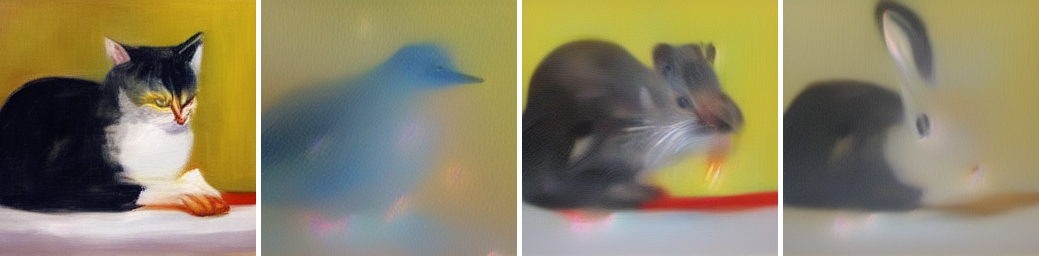

In [21]:
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "bird": .35, "mouse": .2, "rabbit": .2}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)